# Evalute models and plot training history

In [1]:
import pickle
from matplotlib import pyplot as plt
from keras.models import Model, load_model
from keras.datasets import cifar10
from keras.utils import np_utils
import numpy as np
import pandas as pd
from scipy.special import softmax

Using TensorFlow backend.


### Define functions

In [2]:
def getEvalDataset():   
    (x_train, y_train_hard), (x_test, y_test_hard) = cifar10.load_data()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    #Z score
    mean = np.mean(x_train, axis=(0, 1, 2, 3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    x_train = (x_train - mean) / (std + 1e-7) 
    x_test = (x_test - mean) / (std + 1e-7)
    
    num_classes = 10
    y_train_hard = np_utils.to_categorical(y_train_hard, num_classes) #2 One hot encoding
    y_test_hard = np_utils.to_categorical(y_test_hard, num_classes)
    
    return (x_train, y_train_hard),(x_test, y_test_hard)



def plotAcc(i, T):
    if T == 0: #Hard labels, benchmark model
        train_log = 'Hard_trainLog.pkl' 
    else:
        train_log = 't' + str(T)+ '_trainLog.pkl'        
        
    fig = plt.figure(1)    
    fig.tight_layout()
    fig.set_figheight(13)
    fig.set_figwidth(16)
    ax = fig.add_subplot(3,3,i+1)   
    
    log_data = pickle.load(open(train_log, "rb")) 
    ax.plot(log_data['acc'])
    ax.plot(log_data['val_acc'])
    ax.set_title('model accuracy' + "  T=" + str(T))
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper left')   
            
    
    
def getAcc(T):
    if T == 0: #Hard labels, benchmark model
        model = load_model('SmallModel_Hard.h5')    
    else:
        model = load_model('SmallModel_t' + str(T) + '.h5')
        
    scores = model.evaluate(x_test, y_test_hard, verbose=0)
    acc = scores[1]*100
    
    return acc
    
    
    
def getWeightedAcc(T, predHard, y_test_hard):    
    modelT = load_model('SmallModel_t' + str(T) + '.h5')  
    predT = modelT.predict(x_test)    
        
    best_acc = 0
    for i in range(1, 20): 
        comb = np.add(predHard*(2-(0.10*i)), predT*(0+0.10*i)) # Ratios
        
        pred = comb / 2  #Normalize to get real percentages again

        pred = np.argmax(pred, axis=1)
        real = np.argmax(y_test_hard, axis=1)

        error = np.sum(np.not_equal(pred, real)) / real.shape[0]
        acc = 1-error #Get new weighted accuracy
        
        if acc > best_acc:
            best_acc = acc
            best_ratio = (2-(0.10*i))/2   
    
    comb = np.add(predHard, predT) # 1:1 ratio
    pred = comb / 2  #Normalize to get real percentages again

    pred = np.argmax(pred, axis=1)
    real = np.argmax(y_test_hard, axis=1)

    error = np.sum(np.not_equal(pred, real)) / real.shape[0]
    acc_ratio_1to1 = 1-error #Get new weighted accuracy 

    return acc_ratio_1to1, best_ratio, best_acc   

### Load dataset

In [3]:
(x_train, y_train_hard),(x_test, y_test_hard) = getEvalDataset()

### Specify temperatures

In [10]:
temperatures = [0, 1, 2, 3, 4, 5]

### Plot accuracies

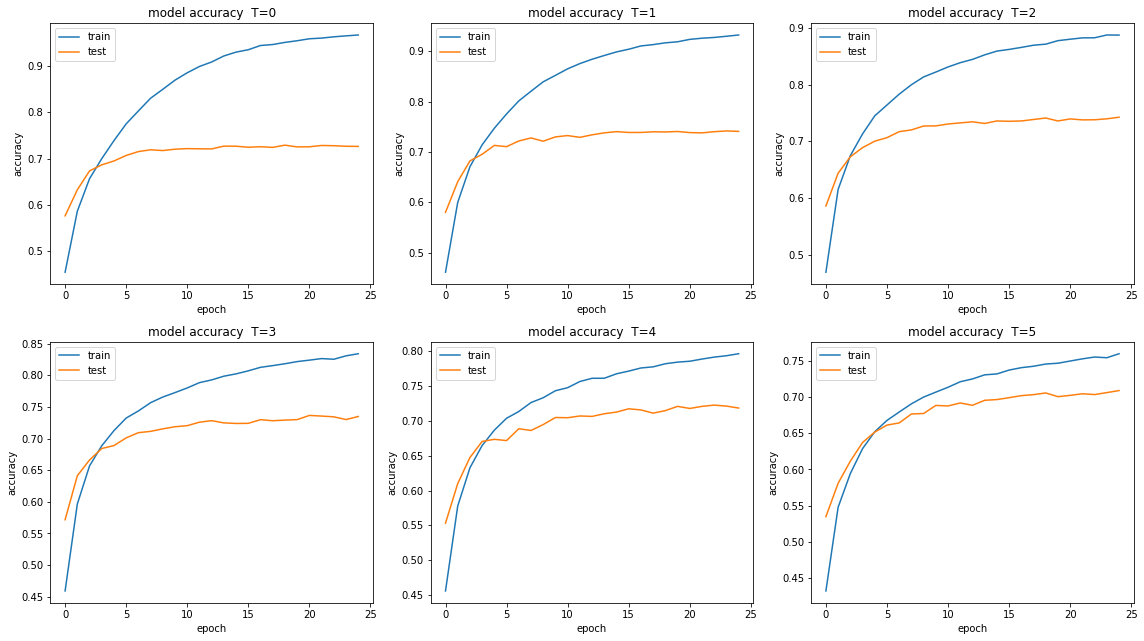

In [12]:
for i, T in enumerate(temperatures):     
    plotAcc(i, T)   # T=0 is the Hard model 

 ### Store model accuracies

In [13]:
model_acc = []

for i, T in enumerate(temperatures):    
    acc = getAcc(T)   
    model_acc.append(acc) 

### Store weighted accuracies

In [14]:
modelHard = load_model('SmallModel_Hard.h5')
predHard = modelHard.predict(x_test)
weighted_acc_1to1 = [None]
weighted_acc_best = [None]
best_ratio_percent_HardModel = [None]

for i, T in enumerate(temperatures[1:]):     
    acc_1to1, ratio, acc = getWeightedAcc(T, predHard, y_test_hard)
    
    weighted_acc_1to1.append(acc_1to1) #Accuracy 1:1 weighing
    weighted_acc_best.append(acc) #Best accuracy from best ratio weighing
    best_ratio_percent_HardModel.append(ratio) #Best weighing ratio found    

### Show model architecture

In [15]:
model = load_model('SmallModel_Hard.h5') 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

### Display DataFrame

In [16]:
df = pd.DataFrame(
    {
        "Temperatures": ['Hard labels', '1', '2', '3', '4', '5'],
        "Small_Model_Acc": model_acc, #Model accuracy from one single trained model
        "Weighted_1to1_Acc": weighted_acc_1to1, #Hard model and soft model weighted 1:1
        "Weighted_BestRatio_Acc": weighted_acc_best, #Accuracy from best weighted ratio  
        "Weighted_BestRatio_Percent_HardModel": best_ratio_percent_HardModel, # That ratio        
    }
)

df

,Temperatures,Small_Model_Acc,Weighted_1to1_Acc,Weighted_BestRatio_Acc,Weighted_BestRatio_Percent_HardModel
0,Hard labels,72.64,NaN,NaN,NaN
1,1,74.07,0.7461,0.7513,0.35
2,2,74.25,0.7440,0.7551,0.30
3,3,73.50,0.7370,0.7518,0.15
4,4,71.84,0.7344,0.7452,0.15
5,5,70.88,0.7309,0.7412,0.20


### Complex model evaluation

In [22]:
#model = load_model('TestModel.h5')
scores = model.evaluate(x_test, y_test_hard, batch_size=128, verbose=0)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))


Test result: 88.790 loss: 0.451
